In [ ]:
import numpy as np
from astropy.io import fits

# Data Reduction For 433 Eros observation

### Telescope: 1m Nickel, Lick Observatory
### Observers: LK,MB
### Obs_Date: 09/25/2023

## Grabbing fits files

In [ ]:
def get_fits(n_1,n_2=None):
    """
    Function to load data from obs fits files
    
    Parameters:
    -----------
    n_1:int - Starting file number
    n_2:int - Ending file number
    """
    if n_2 == None:
        n_2=n_1
    
    hdus = [fits.open(f'data-2023-09-25-nickel-Andrew.Skemer/d{i+2000}.fits')[0].data for i in range(n_1,n_2+1)]
    return hdus

#Bias 2000-2002
bias_frames = get_fits(0,2)

#Darks 2003-2005
dark_frames = get_fits(3,5)

#Sky_Flats V 2062-2064
Sky_V = get_fits(62,64)

#LM Erros - Read 1 2086-2089
LM_Eros_1 = get_fits(86,89)

#LM_Eros - Read 2 2154-2158
LM_Eros_2 = get_fits(154,158)

In [ ]:
def get_median(frame,exp_time=1):
    # Calculating median
    data = np.stack(frame,axis=0)
    data_median = np.nanmedian(data,axis=0)
    
    #Geting Count per second
    data_cps = data_median/exp_time
    return data_median,data_cps

## Making Bias

In [ ]:
# For the bias
bias,bias_cps = get_median(bias_frames)

## Making Dark

In [ ]:
# For the Dark Times, exp_time=30
dark,dark_cps = get_median(dark_frames,30)
dark_final = dark_cps-bias

## Making Flats

In [ ]:
# For Sky_Flats_V
_sky = []
for i in range(3):
    _Sky_V = Sky_V[0]-bias
    sky_norm = _Sky_V/np.nanmedian(_Sky_V)
    _sky.append(sky_norm)
Sky_V_norm = np.stack(_sky,axis=0)
Sky_V_final,sky_cps = get_median(Sky_V_norm)

## Making Science Image

# $ScienceImg = \frac{(ScienceFrame-bias-darks)}{FlatFrame}$

In [ ]:
# Get median Science images

# For image in read 1
LM_1,LM_1_cps = get_median(LM_Eros_1,30)
LM_1_final = (LM_1_cps - dark_final - bias)/Sky_V_final

# For image in read 1
LM_2,LM_2_cps = get_median(LM_Eros_2,30)
LM_2_final = (LM_2_cps - dark_final - bias)/Sky_V_final

## Making Final fits files

In [ ]:
#Creating fits files using headers from obs

# For read 1
hdu_1 = fits.open(f'data-2023-09-25-nickel-Andrew.Skemer/d2086.fits')
hdr_1 = hdu_1[0].header

new_hdu_1 = fits.PrimaryHDU(data=LM_1_final,header=hdr_1)

hdul = fits.HDUList([new_hdu_1])

# Specify the filename for the FITS file
fits_filename = '433_Eros_R1.fits'

hdul.writeto(fits_filename, overwrite=True)

In [ ]:
#Creating fits files using headers from obs

# For read 1
hdu_2 = fits.open(f'data-2023-09-25-nickel-Andrew.Skemer/d2158.fits')
hdr_2 = hdu_2[0].header

new_hdu_2 = fits.PrimaryHDU(data=LM_2_final,header=hdr_2)

hdul = fits.HDUList([new_hdu_2])

# Specify the filename for the FITS file
fits_filename = '433_Eros_R2.fits'

hdul.writeto(fits_filename, overwrite=True)

In [ ]:
Read_1	558.412	496.649	865.803	491.497
Read_2	589.352	526.496	858.301	542.49

In [1]:
import pandas as pd

# Positions from ds9_centroids
df = pd.read_csv('obj_pos.csv')
df = df.set_index('obj_name')
df

,ast_x,ast_y,star_x,star_y
obj_name,,,,
Read_1,558.412,496.649,865.803,491.497
Read_2,589.352,536.496,858.301,542.496


In [2]:
del_x_1 = df.loc['Read_1']['ast_x'] - df.loc['Read_1']['star_x']
del_y_1 = df.loc['Read_1']['ast_y'] - df.loc['Read_1']['star_x']
print(del_x_1,del_y_1)

del_x_2 = df.loc['Read_2']['ast_x'] - df.loc['Read_2']['star_x']
del_y_2 = df.loc['Read_2']['ast_y'] - df.loc['Read_2']['star_x']

print(del_x_2,del_y_2)

-307.39099999999996 -369.154
-268.94900000000007 -321.80500000000006


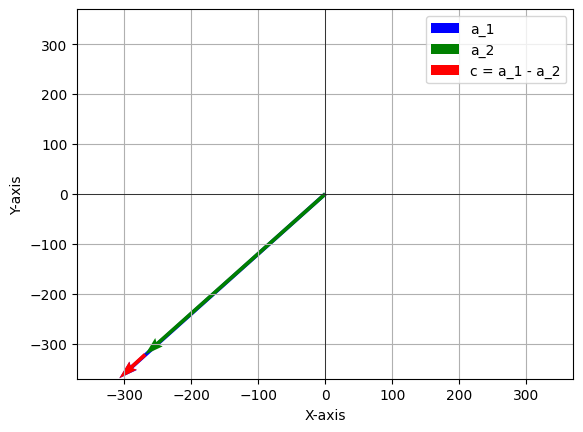

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the components of vectors a_1 and a_2
a1_x = del_x_1
a1_y = del_y_1

a2_x = del_x_2
a2_y = del_y_2

# Calculate the components of vector c (a_1 - a_2)
c_x = a1_x - a2_x
c_y = a1_y - a2_y

# Create a figure and axis
fig, ax = plt.subplots()

# Plot vectors a_1 and a_2
ax.quiver(0, 0, a1_x, a1_y, angles='xy', scale_units='xy', scale=1, color='b', label='a_1')
ax.quiver(0, 0, a2_x, a2_y, angles='xy', scale_units='xy', scale=1, color='g', label='a_2')

# Plot vector c in a different color starting at the tip of a_2
ax.quiver(a2_x, a2_y, c_x, c_y, angles='xy', scale_units='xy', scale=1, color='r', label='c = a_1 - a_2')

# Set axis limits based on vector magnitudes
max_mag = max(abs(a1_x), abs(a1_y), abs(a2_x), abs(a2_y), abs(c_x), abs(c_y))
ax.set_xlim(-max_mag - 1, max_mag + 1)
ax.set_ylim(-max_mag - 1, max_mag + 1)

# Add labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()

# Show the plot
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.savefig('test.jpg')
plt.show()


In [4]:
from astropy.io import fits
hdu = fits.open('433_Eros_R2.fits')
hdr = hdu[0].header
hdr['PIXSCALE'] = 0.184

/tmp/ipykernel_53769/2091709849.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


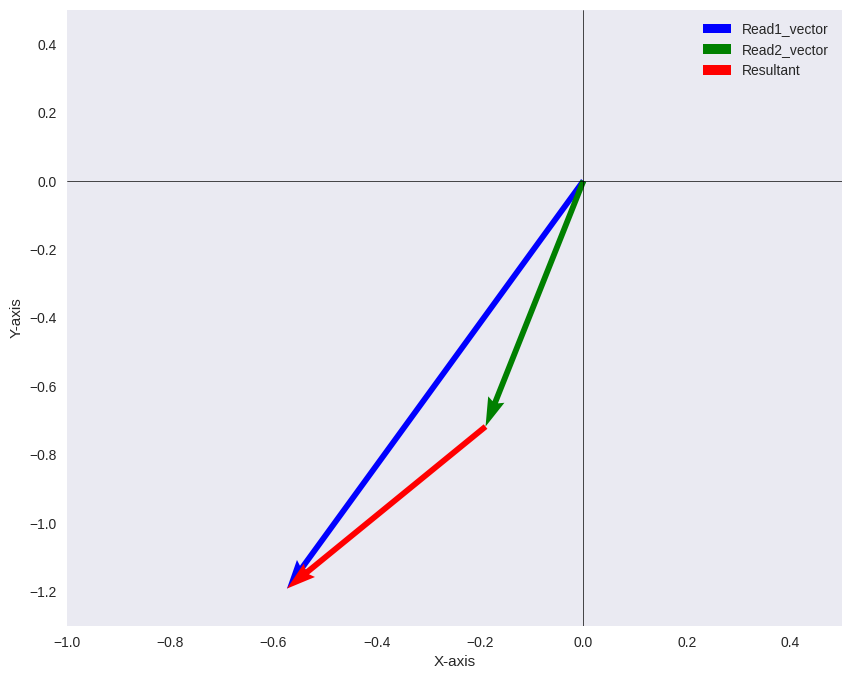

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
x = 250
# Define the components of vectors a_1 and a_2
a1_x, a1_y = -307.39099999999996+x, -369.154+x
a2_x, a2_y = -268.94900000000007+x, -321.80500000000006+x

# Calculate the components of vector c (a_1 - a_2)
c_x = a1_x - a2_x
c_y = a1_y - a2_y

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,8))
# Plot vectors a_1 and a_2 with a scaled factor
scale_factor = 0.01  # Adjust this factor as needed for a noticeable separation
ax.quiver(0, 0, a1_x * scale_factor, a1_y * scale_factor, 
          angles='xy', scale_units='xy', scale=1, color='b', label='Read1_vector')
ax.quiver(0, 0, a2_x * scale_factor, a2_y * scale_factor, 
          angles='xy', scale_units='xy', scale=1, color='g', label='Read2_vector')

# Plot vector c in a different color starting at the tip of a_2
ax.quiver(a2_x * scale_factor, a2_y * scale_factor, c_x * scale_factor, c_y * scale_factor, angles='xy', scale_units='xy', scale=1, color='r', label='Resultant')

# Set axis limits based on vector magnitudes
max_mag = max(abs(a1_x), abs(a1_y), abs(a2_x), abs(a2_y), abs(c_x), abs(c_y)) * scale_factor
ax.set_xlim(-1,0.5)
ax.set_ylim(-1.3,0.5)

# Add labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.legend()
# Show the plot
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.show()


In [7]:
print()

-7.0733279999999805
